In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers import Dense

import sklearn.utils

import pickle
def fnSaveObject(save_object, sFileName):
    with open(sFileName, "wb") as file:
        pickle.dump(save_object, file)

def fnLoadObject(sFileName):
    with open(sFileName, 'rb') as file:
        load_object = pickle.load(file)
    return load_object

sans_models = ['sphere', 'core_shell_sphere', 'ellipsoid', 'core_shell_ellipsoid', 'cylinder', 'core_shell_cylinder', 'three_pearl_necklace', 'lamellar', 'lamellar_hg']
# sans_models = ['core_shell_cylinder', 'core_shell_cylinder', 'core_shell_cylinder', 'core_shell_cylinder']

In [2]:
# data preparation
def y_encode(model, ydata, modellist, ydim):
    def onehot(y_cl, num_classes):
        y = numpy.zeros((len(y_cl), num_classes))
        y[numpy.arange(len(y_cl)), y_cl] = 1
        return y

    result = []
    class_number = None
    for i, modelname in enumerate(modellist):
        # regression outputs
        if model == modelname:
            # fill output for particular model with training values
            result.append(ydata)
            class_number = i
        else:
            # the outputs for the other models are set to zero
            result.append(numpy.zeros(shape=(ydata.shape[0], ydim[i])).astype('float32'))

    # classification output, one-hot encoding for the particular model
    oh = numpy.full((ydata.shape[0]), class_number)
    oh = onehot(oh, len(modellist)).astype('float32')
    result.append(oh)

    return result


# step-by-step model loading and data augmentation
data_x_pandas = []
data_y_pandas = []
data_x = None
data_y = None
ydim = []
for sansmodel in sans_models:
    print(sansmodel)
    data_x_pandas.append(fnLoadObject('train_'+sansmodel+'_x.dat'))
    data_y_pandas.append(fnLoadObject('train_'+sansmodel+'_y.dat'))
    # number of parameters knowing that scale and sld_solvent will be dropped
    ydim.append(data_y_pandas[-1][0].shape[0]-2)


for i, sansmodel in enumerate(sans_models):
    parlist = data_y_pandas[i][0]['par'].values.tolist()
    modparlist = []
    for par in parlist:
        if 'sld' in par and par != 'sld_solvent':
            modparlist.append(par)

    for frame in data_y_pandas[i]:
        solvent_sld = frame.loc[frame.par =='sld_solvent', 'value'].squeeze()

        # reduce all sld values in the model to their difference to the solvent sld
        for par in modparlist:
            sld = frame.loc[frame.par == par, 'value'].squeeze()
            frame.loc[frame.par == par, 'value'] = solvent_sld - sld

        # remove solvent sld and scale factor, since they cannot be resolved
        index_names = frame[ frame['par'] == 'scale'].index
        frame.drop(index_names, inplace = True)
        index_names = frame[ frame['par'] == 'sld_solvent'].index
        frame.drop(index_names, inplace = True)

    new_x = numpy.row_stack([frame['I'].to_numpy() for frame in data_x_pandas[i]])
    new_x = numpy.log10(new_x).astype('float32')
    new_y = numpy.row_stack([frame['value'].to_numpy() for frame in data_y_pandas[i]]).astype('float32')
    new_y = y_encode(sansmodel, new_y, sans_models, ydim)

    if data_x is None:
        data_x = new_x
    else:
        data_x = numpy.concatenate((data_x, new_x), axis=0)

    if data_y is None:
        data_y = new_y
    else:
        for j in range(len(sans_models)+1):
            data_y[j] = numpy.concatenate((data_y[j], new_y[j]), axis=0)

# Prepare for proper training
# randomly sort examples
data_y.append(data_x)
data_y = sklearn.utils.shuffle(*data_y, random_state=0)
data_x = data_y[-1]
data_y = data_y[:-1]
pass

sphere
core_shell_sphere
ellipsoid
core_shell_ellipsoid
cylinder
core_shell_cylinder
three_pearl_necklace
lamellar
lamellar_hg


In [3]:
# model construction
input_dim = data_x.shape[1]
n_input_layers = 4
n_branch_layers = 4
output_layers = []

node_n = input_dim

activation = "relu"
reg_strategy = keras.regularizers.l1_l2(l1=0.001, l2=0.001)  # use L1 and L2 regularization

# common input layers
sans_input = keras.Input(shape=(input_dim, ))
x = layers.Dense(node_n, activation=activation, kernel_regularizer=reg_strategy)(sans_input)
for _ in range(n_input_layers-1):
    x = layers.Dense(node_n, activation=activation, kernel_regularizer=reg_strategy)(x)

# split into different model regression layers plus classification
# regression
for j, sans_model in enumerate(sans_models):
    x2 = layers.Dense(node_n, activation=activation, kernel_regularizer=reg_strategy)(x)
    for i in range(n_branch_layers-1):
        x2 = layers.Dense(node_n, activation=activation, kernel_regularizer=reg_strategy)(x2)
    output_layers.append(Dense(data_y[j].shape[1], activation="linear")(x2))

# classification
x2 = layers.Dense(node_n, activation=activation, kernel_regularizer=reg_strategy)(x)
for _ in range(n_branch_layers-1):
    x2 = layers.Dense(node_n, activation=activation, kernel_regularizer=reg_strategy)(x2)
output_layers.append(Dense(len(sans_models), activation="softmax")(x2))

#model
model = keras.Model(
    inputs=[sans_input],
    outputs=output_layers,
)


In [4]:
def fn_regression_loss(y_true, y_pred):
    # rank = tf.rank(y_true)
    # if rank == 2:
    pattern = tf.zeros_like(y_true[0])
    shape = y_true.shape[1]
    mask = tf.math.equal(y_true, pattern)
    split = tf.split(mask, num_or_size_splits=shape, axis=1)

    '''
        else:
        # unsure this function will ever get a one-dimensional vector
        pattern = tf.zeros_like(y_true)
        shape = y_true.shape[0]
        mask = tf.math.equal(y_true, pattern)
        split = tf.split(mask, num_or_size_splits=shape, axis=0)
    '''

    y_mult = split[0]
    for i in range(1, shape):
        y_mult = tf.math.logical_and(y_mult, split[i])
    y_mult = tf.where(y_mult, 0., 1.)

    mse = tf.reduce_mean((tf.squeeze(y_pred)-tf.squeeze(y_true))**2, axis=1)
    mse_masked = tf.math.multiply(tf.squeeze(mse), tf.squeeze(y_mult))
    result = tf.reduce_mean(mse_masked)

    return result

opt = keras.optimizers.Adam(learning_rate=0.0005)
losslist = [fn_regression_loss] * len(sans_models)
losslist.append(keras.losses.CategoricalCrossentropy(from_logits=False))

model.compile(optimizer=opt, loss=losslist)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 105)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 105)          11130       ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 105)          11130       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 105)          11130       ['dense_1[0][0]']                
                                                                                              

In [5]:
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [6]:
epochs_n = 1000
batch_size = 16

save_period = 20  # after how many epochs the model should be saved?
chkpnt_saver = keras.callbacks.ModelCheckpoint("weights-{epoch:02d}.hdf5",
                                               save_weights_only=False,
                                               save_freq='epoch')


history = model.fit(data_x, data_y,
                    epochs=epochs_n,
                    batch_size=batch_size,
                    verbose=1,
                    validation_split = 0.3,
                    shuffle=False,
                    callbacks=[chkpnt_saver]
                    )


Epoch 1/1000
3938/3938 [==============================] - 18s 3ms/step - loss: 1553.0266 - dense_8_loss: 32.6719 - dense_13_loss: 162.0969 - dense_18_loss: 144.6288 - dense_23_loss: 106.7746 - dense_28_loss: 143.7196 - dense_33_loss: 203.3175 - dense_38_loss: 694.1372 - dense_43_loss: 45.7900 - dense_48_loss: 2.1745 - dense_53_loss: 2.0977 - val_loss: 1488.2960 - val_dense_8_loss: 13.4027 - val_dense_13_loss: 162.3009 - val_dense_18_loss: 134.0067 - val_dense_23_loss: 112.0425 - val_dense_28_loss: 112.2816 - val_dense_33_loss: 185.7564 - val_dense_38_loss: 722.9139 - val_dense_43_loss: 29.3691 - val_dense_48_loss: 1.8917 - val_dense_53_loss: 2.0422
Epoch 2/1000
3938/3938 [==============================] - 12s 3ms/step - loss: 1253.3992 - dense_8_loss: 12.1674 - dense_13_loss: 145.1384 - dense_18_loss: 119.9566 - dense_23_loss: 96.7198 - dense_28_loss: 108.5167 - dense_33_loss: 184.1847 - dense_38_loss: 553.5564 - dense_43_loss: 17.9306 - dense_48_loss: 1.9764 - dense_53_loss: 2.0092 - 

In [7]:
model.save('ml_model')

INFO:tensorflow:Assets written to: ml_model\assets


INFO:tensorflow:Assets written to: ml_model\assets


In [8]:
# The history object returned by the model training above
# contains the values of the loss function (the mean-squared-error)
# at different epochs
# We discard the first epoch as the loss value is very high,
# obscuring the rest of the distribution
train_loss = history.history["loss"][1:]
test_loss = history.history["val_loss"][1:]

In [9]:
print(history.history.keys())

dict_keys(['loss', 'dense_8_loss', 'dense_13_loss', 'dense_18_loss', 'dense_23_loss', 'dense_28_loss', 'dense_33_loss', 'dense_38_loss', 'dense_43_loss', 'dense_48_loss', 'dense_53_loss', 'val_loss', 'val_dense_8_loss', 'val_dense_13_loss', 'val_dense_18_loss', 'val_dense_23_loss', 'val_dense_28_loss', 'val_dense_33_loss', 'val_dense_38_loss', 'val_dense_43_loss', 'val_dense_48_loss', 'val_dense_53_loss'])


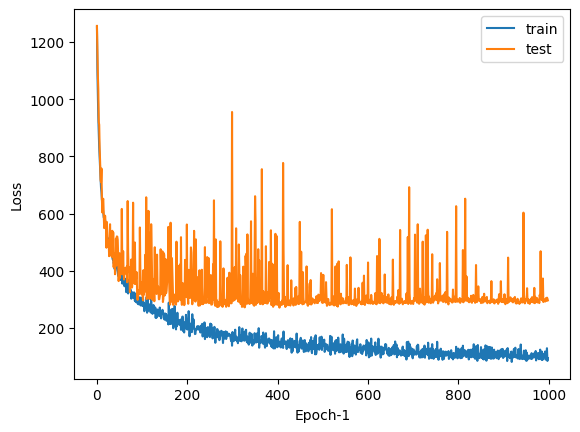

In [10]:
# Prepare and plot loss over time
plt.plot(train_loss,label="train")
plt.plot(test_loss,label="test")
plt.legend()
plt.xlabel("Epoch-1")
plt.ylabel("Loss")
plt.show()

In [11]:
# After the training:

# Prepare scatter plot
y_pred = model.predict(data_x)


2813/2813 [==============================] - 3s 848us/step


In [12]:
y_pred

[array([[ 1.73562546e+02, -1.16238743e-01],
        [ 1.58452316e+02, -1.10880464e-01],
        [ 1.51077332e+02, -1.08265460e-01],
        ...,
        [ 2.28479900e+01, -2.19759747e-01],
        [ 4.89121475e+01, -1.77158475e-01],
        [ 8.10881271e+01, -1.37873411e-01]], dtype=float32),
 array([[ 2.9394749e+01,  1.2072916e-01,  1.2279335e-01,  1.4522882e+02],
        [ 1.4778801e+02,  2.5640970e-01, -2.1770801e-02,  1.5696414e+02],
        [ 1.1435495e+02,  1.8924077e-01, -9.6299618e-02,  1.3893344e+02],
        ...,
        [ 2.8330418e+01, -1.5283115e-03, -1.0556224e-01,  2.8355663e+01],
        [ 2.6171089e+01,  6.4745501e-02, -2.3078230e-01,  3.3316711e+01],
        [ 2.9299633e+01,  2.5739860e-02, -1.1919513e-01,  5.7981209e+01]],
       dtype=float32),
 array([[ 1.7162982e+02,  1.7337279e+02, -4.7298256e-01],
        [ 1.2087509e+02,  2.2882585e+02, -6.0891294e-01],
        [ 2.0124734e+02,  8.6814011e+01, -6.9533026e-01],
        ...,
        [ 1.3490448e+01,  9.8252640e+0

62999
radius
Correlation coefficient: [[1.         0.06769316]
 [0.06769316 1.        ]]


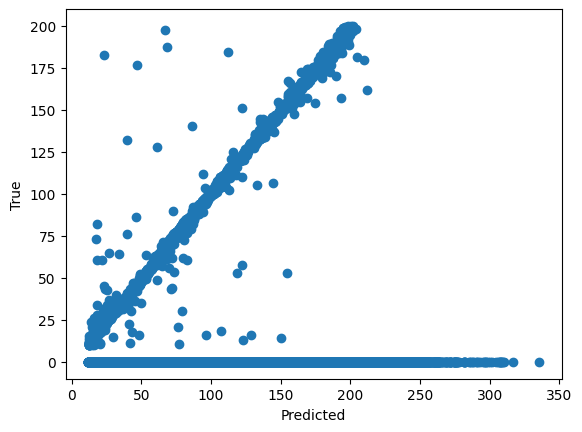

sld
Correlation coefficient: [[ 1.         -0.00430466]
 [-0.00430466  1.        ]]


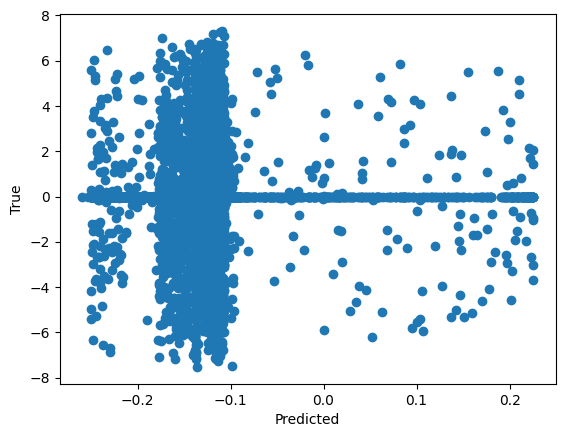

In [20]:
# sphere
j = 0
valstart = int(0.7 * y_pred[j].shape[0])
print(valstart)
for i in range(y_pred[j].shape[1]):
    print(data_y_pandas[j][0]['par'].iloc[i])
    print("Correlation coefficient:", numpy.corrcoef(y_pred[j][valstart:, i],data_y[j][valstart:, i]))
    plt.scatter(y_pred[j][valstart:, i],data_y[j][valstart:, i])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

62999
radius
Correlation coefficient: [[1.         0.30795714]
 [0.30795714 1.        ]]


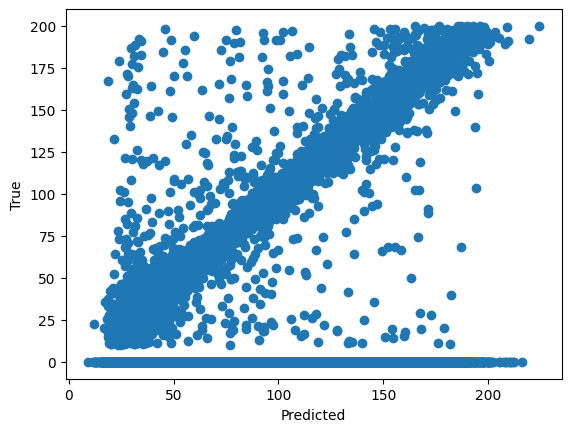

sld_core
Correlation coefficient: [[1.00000000e+00 8.80646717e-04]
 [8.80646717e-04 1.00000000e+00]]


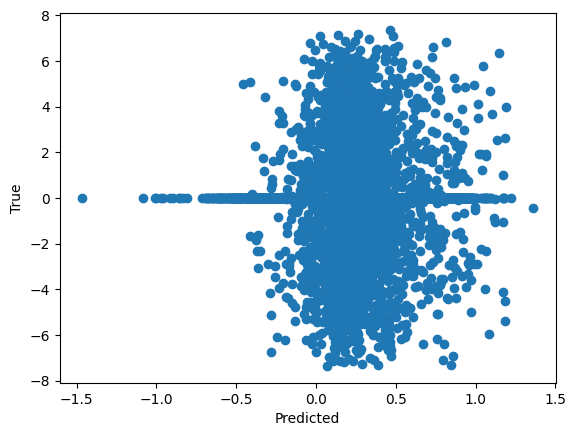

sld_shell
Correlation coefficient: [[ 1.        -0.0042181]
 [-0.0042181  1.       ]]


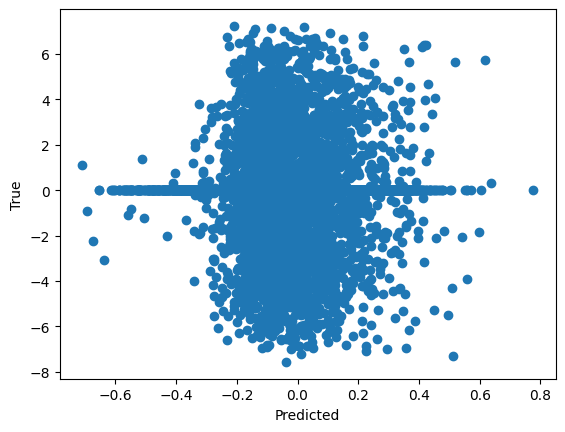

thickness
Correlation coefficient: [[1.         0.20717172]
 [0.20717172 1.        ]]


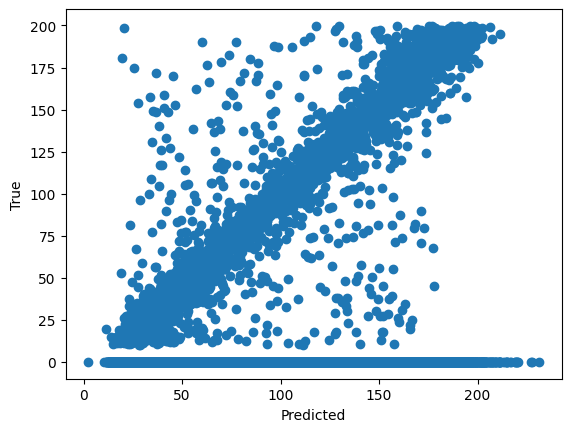

In [21]:
# core shell sphere
j = 1
valstart = int(0.7 * y_pred[j].shape[0])
print(valstart)
for i in range(y_pred[j].shape[1]):
    print(data_y_pandas[j][0]['par'].iloc[i])
    print("Correlation coefficient:", numpy.corrcoef(y_pred[j][valstart:, i],data_y[j][valstart:, i]))
    plt.scatter(y_pred[j][valstart:, i],data_y[j][valstart:, i])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

62999
radius_equatorial
Correlation coefficient: [[ 1.        -0.0721398]
 [-0.0721398  1.       ]]


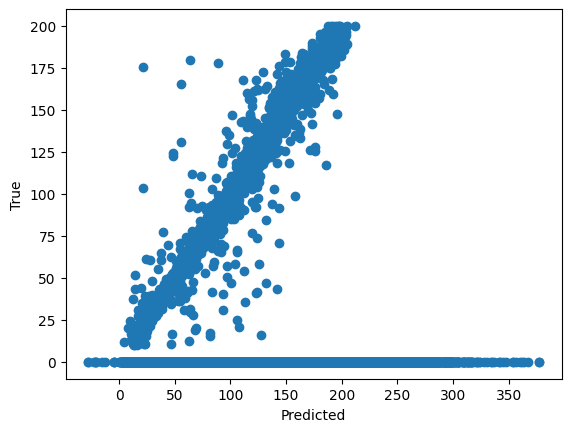

radius_polar
Correlation coefficient: [[1.         0.12334873]
 [0.12334873 1.        ]]


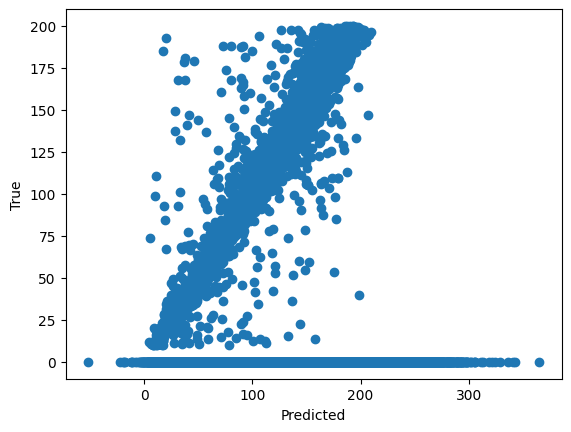

sld
Correlation coefficient: [[1.0000000e+00 4.2745249e-04]
 [4.2745249e-04 1.0000000e+00]]


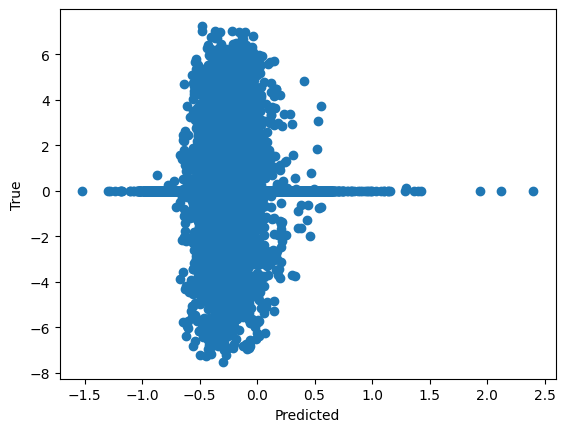

In [15]:
# three-pearl necklace
j = 2
valstart = int(0.7 * y_pred[j].shape[0])
print(valstart)
for i in range(y_pred[j].shape[1]):
    print(data_y_pandas[j][0]['par'].iloc[i])
    print("Correlation coefficient:", numpy.corrcoef(y_pred[j][valstart:, i],data_y[j][valstart:, i]))
    plt.scatter(y_pred[j][valstart:, i],data_y[j][valstart:, i])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

62999
radius_equat_core
Correlation coefficient: [[1.         0.25398579]
 [0.25398579 1.        ]]


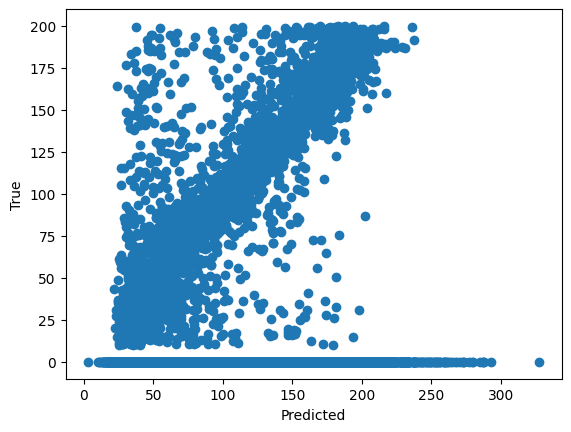

sld_core
Correlation coefficient: [[1.         0.00512859]
 [0.00512859 1.        ]]


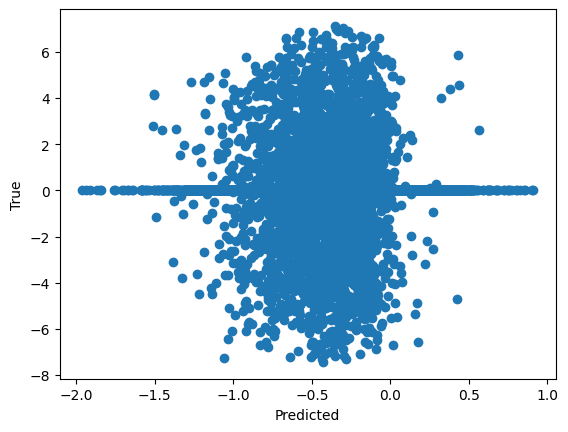

sld_shell
Correlation coefficient: [[1.         0.01418712]
 [0.01418712 1.        ]]


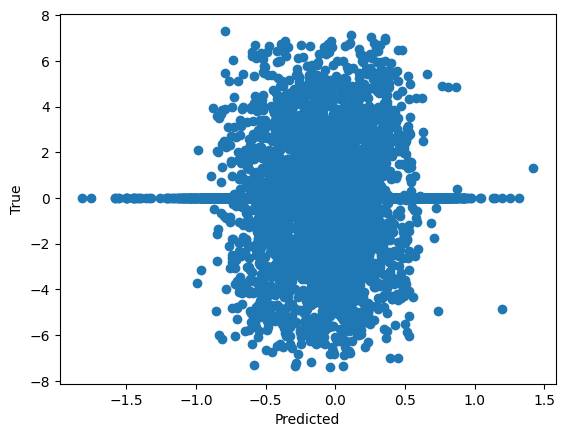

thick_shell
Correlation coefficient: [[1.         0.30252214]
 [0.30252214 1.        ]]


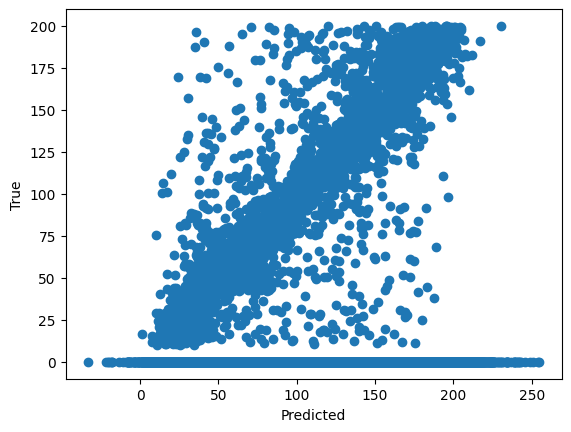

x_core
Correlation coefficient: [[ 1.         -0.05337114]
 [-0.05337114  1.        ]]


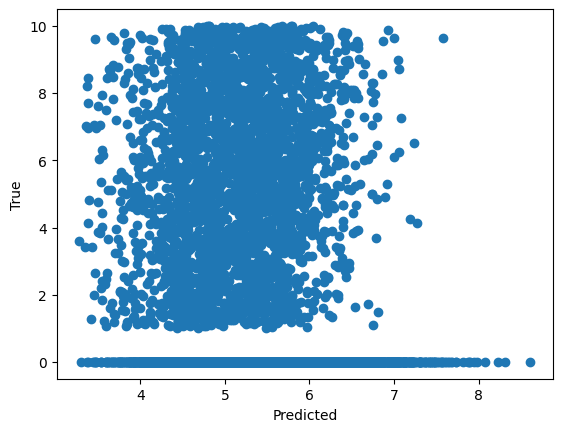

x_polar_shell
Correlation coefficient: [[1.         0.15770509]
 [0.15770509 1.        ]]


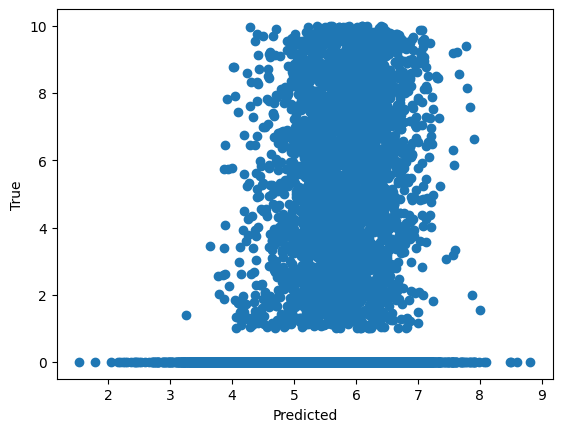

In [16]:
# lamellar
j = 3
valstart = int(0.7 * y_pred[j].shape[0])
print(valstart)
for i in range(y_pred[j].shape[1]):
    print(data_y_pandas[j][0]['par'].iloc[i])
    print("Correlation coefficient:", numpy.corrcoef(y_pred[j][valstart:, i],data_y[j][valstart:, i]))
    plt.scatter(y_pred[j][valstart:, i],data_y[j][valstart:, i])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [17]:
len(data_y_pandas)

9

In [19]:
# class labels
j = 9
valstart = int(0.7 * y_pred[j].shape[0])
print(valstart)
true_class = tf.argmax(data_y[j][valstart:, :], 1)
pred_class = tf.argmax(y_pred[j][valstart:, :], 1)
cmatrix = tf.math.confusion_matrix(true_class, pred_class)

# normalization
cmatrix = cmatrix / numpy.sum(cmatrix) * float(cmatrix.shape[0])
cmatrix

62999


<tf.Tensor: shape=(9, 9), dtype=float64, numpy=
array([[8.68967816e-01, 1.63327284e-02, 6.99974075e-03, 3.33320988e-03,
        2.49990741e-02, 2.66656790e-03, 6.33309877e-02, 9.99962964e-04,
        9.99962964e-04],
       [1.56660864e-01, 7.26639754e-01, 6.33309877e-03, 2.09992223e-02,
        1.16662346e-02, 3.66653087e-02, 4.36650494e-02, 2.33324692e-03,
        1.66660494e-03],
       [1.96326062e-01, 3.33320988e-03, 5.56979371e-01, 6.33309877e-03,
        2.20991815e-01, 4.66649383e-03, 3.19988149e-02, 1.33328395e-03,
        0.00000000e+00],
       [4.33317285e-03, 4.86648643e-02, 2.49990741e-02, 7.86970853e-01,
        1.29995185e-02, 1.07329358e-01, 1.86659753e-02, 7.66638273e-03,
        2.66656790e-03],
       [4.96648272e-02, 2.99988889e-03, 1.78660050e-01, 1.19995556e-02,
        7.01974001e-01, 6.33309877e-03, 2.19991852e-02, 4.66649383e-03,
        2.66656790e-03],
       [6.99974075e-03, 1.61327358e-01, 6.03310988e-02, 1.82326580e-01,
        9.33298767e-02, 4.58983001e